In [1]:
# CUDA Toolkit = 10.1
# Remaining libraries = refer to requirements.txt

In [1]:
import numpy as np
import os
import time

from functions.evaluation import Evaluation
from functions.plotting import Plotting
from functions.utilities import Utilities
from functions.tuning import Tuning

import torch.optim as optim

%matplotlib inline

In [2]:
# Hyperparameters
BATCH_SIZES = [256, 128, 64, 32]
CLASS_NUM = 6
EPOCHS = 10000
FILE_PATH = "dataset/resized"
HIDDEN_LAYER_SIZES = [[512, 256], [512, 512], [1024, 512], [1024, 1024], 
                      [1024], [512], 
                      [1024, 512, 256]]
K_PREDS = 3
LEARNING_RATE = 0.001
SPLIT_SIZE = 0.15
SEED = 1

In [3]:
# Instantiate classes
utils = Utilities()
plotting = Plotting()
evaluate = Evaluation()
tuning = Tuning()

In [4]:
dataset = utils.augment_data(FILE_PATH)

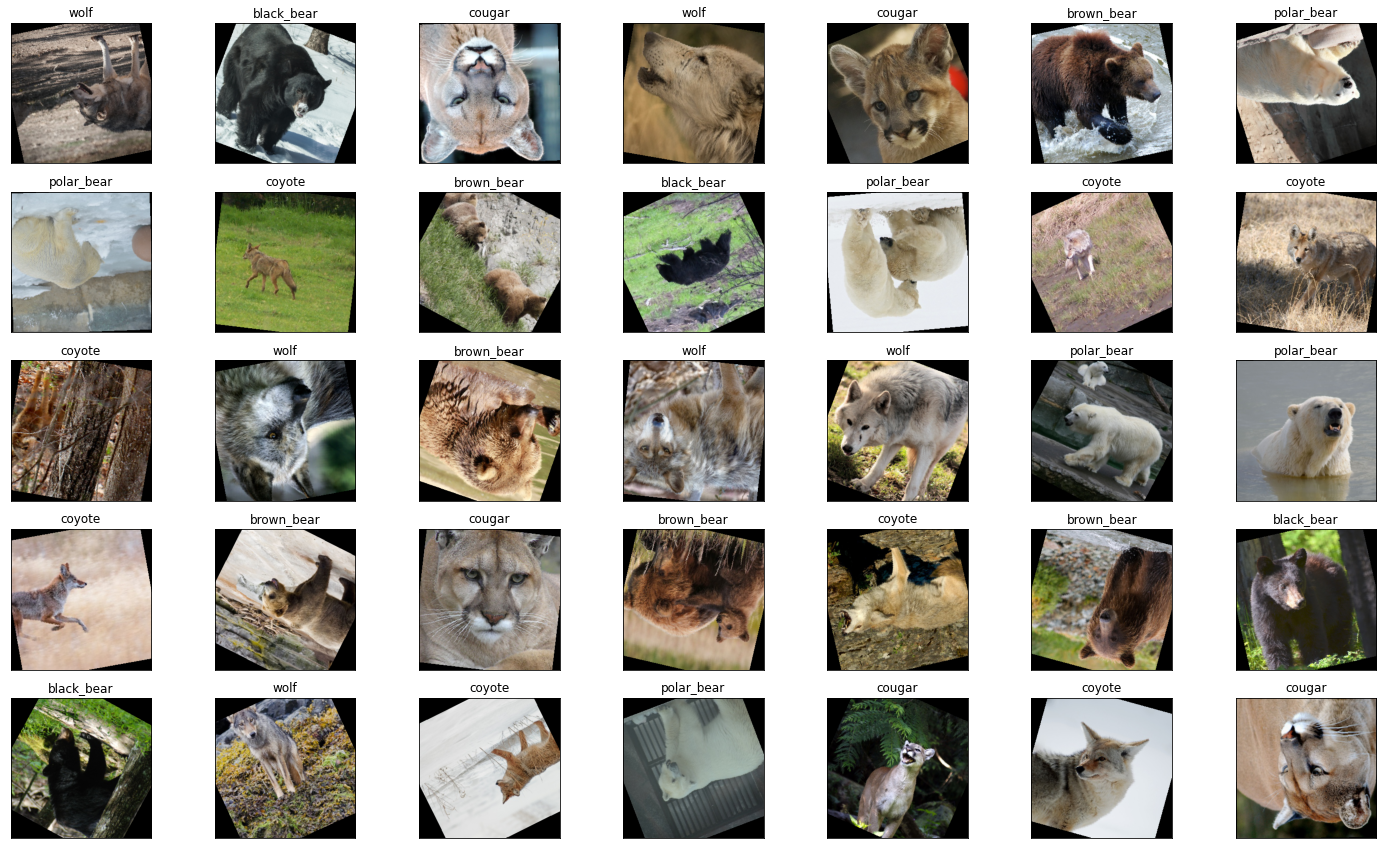

In [5]:
_, _, train_loader = utils.split_data(dataset, BATCH_SIZES[0], SPLIT_SIZE, SEED)
class_labels = np.array(list(dataset.class_to_idx), dtype = object)
train_iter = iter(train_loader)
images, labels = train_iter.next()
images = images.numpy()

plotting.visualise_images(images, labels, class_labels)

In [6]:
DEVICE = utils.select_processing_unit()

GPU


In [10]:
model_stats = []
counter = 1
model_num = len(BATCH_SIZES) * len(HIDDEN_LAYER_SIZES)
start_time = time.time()

for batch in BATCH_SIZES:
    valid_loader, test_loader, train_loader = utils.split_data(dataset, batch, 
                                                               SPLIT_SIZE, SEED)
    
    for hidden_layers in HIDDEN_LAYER_SIZES:
        # Create the model and set its name
        model = tuning.create_model(CLASS_NUM, hidden_layers)
        model_name = f"inception_{str(batch)}"
        
        for size in hidden_layers:
            model_name += f"_{str(size)}"
        
        save_file_path = f"models/{model_name}.pt"
        
        # Skip the model training, if already trained
        if os.path.isfile(save_file_path):
            print(f"({counter}/{model_num}) Model: '{model_name}' has been trained.")
        else:
            print(f"({counter}/{model_num}) Training model: '{model_name}' -", end=" ")
            model.to(DEVICE)
            criterion = nn.NLLLoss() # negative log likelihood loss
            optimizer = torch.optim.Adam(model.fc.parameters(), lr = LEARNING_RATE)
            evaluate.train_model(model, train_loader, valid_loader, criterion, 
                                 optimizer, save_file_path, EPOCHS)
            print("Complete.")

            print(f"\tEvaluating performance metrics -", end=" ")
            metrics = evaluate.test_model(model, model_name, test_loader, K_PREDS)
            print("Complete.")
        counter += 1
    print(f"All models trained on {batch} batches.")

utils.time_taken(time.time() - start_time)

28


In [43]:
all_stats = plotting.stats_table(model_stats)
all_stats.style.hide_index()

Name,Accuracy,Top 1 Error,Top 3 Error,Precision,Recall,F1 Score
inception_64_256_512,0.796875,0.203125,0.046875,0.962264,0.962264,0.962264


In [42]:
# Get best model stats
idx = all_stats['Accuracy'].idxmax()
best_model = all_stats.iloc[idx, :]
best_model_stats = stats_table([best_model])
best_model_stats.style.hide_index()

Name,Accuracy,Top 1 Error,Top 3 Error,Precision,Recall,F1 Score
inception_64_256_512,0.796875,0.203125,0.046875,0.962264,0.962264,0.962264


In [ ]:
best_model_name, best_hidden_sizes = tuning.save_best_model(best_model_stats, CLASS_NUM)